# E.coli Model Data Generation

 This section covers the initial stages of Generation of the dataset, from loading raw data to engineering features and building dataset for training AI models.

## Required Libraries

This part includes the necessary Python libraries for data processing, machine learning, and visualization. 

In [1]:
# required libraries
import os
import math
import time
from pathlib import Path
import tempfile
import functools
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
pd.set_option("display.max_rows", None)
import scipy, joblib
from scipy import stats
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
import sklearn
import xgboost as xg
from matplotlib.pyplot import figure
from matplotlib import pyplot
from IPython.display import display, clear_output
import logging
from meteostat import Point, Daily, Hourly
from datetime import datetime, timedelta
import urllib
from urllib.error import HTTPError
import pickle
import requests
import folium
from folium.plugins import HeatMap, Draw, HeatMapWithTime
from tqdm.contrib.concurrent import process_map
import uuid
import pyarrow as pa
import pyarrow.parquet as pq
import warnings
warnings.filterwarnings('ignore')

In [ ]:
cache_dir = "data"
cache_dir = Path(tempfile.gettempdir()) if cache_dir is None else Path(cache_dir)
cache_dir = cache_dir 
        
# make cache dir
cache_dir.mkdir(exist_ok=True, parents=True)

## Data Extraction

This step involves reading and loading the raw dataset, typically from CSV, Excel, JSON, RDF or a database. It also includes an initial inspection of the data (e.g., checking for missing values, data types, and summary statistics).

Here we load EA water quality archive from our repo. Data is loaded and cocatenated from 2000 til mid 2024.

[This is the link to source repo.](https://environment.data.gov.uk/water-quality/view/download/new)

In [2]:
# Loading WQ_EA Data
path = "gs://rdmai_dev_data/raw/Water_Quality_EA/2000.csv"
dataset = pd.read_csv(path, sep=",")
for i in range(1,10):
    a = "{0}{1}.csv".format('gs://rdmai_dev_data/raw/Water_Quality_EA/200', i)
    print(i)
    dataset = pd.concat([dataset, pd.read_csv(a)]).reset_index(drop=True)
for i in range(10,25):
    a = "{0}{1}.csv".format('gs://rdmai_dev_data/raw/Water_Quality_EA/20', i)
    print(i)
    dataset = pd.concat([dataset, pd.read_csv(a)]).reset_index(drop=True)
dataset.shape

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


(68470660, 17)

In [3]:
dataset.head()

,@id,sample.samplingPoint,sample.samplingPoint.notation,sample.samplingPoint.label,sample.sampleDateTime,determinand.label,determinand.definition,determinand.notation,resultQualifier.notation,result,codedResultInterpretation.interpretation,determinand.unit.label,sample.sampledMaterialType.label,sample.isComplianceSample,sample.purpose.label,sample.samplingPoint.easting,sample.samplingPoint.northing
0,http://environment.data.gov.uk/water-quality/d...,http://environment.data.gov.uk/water-quality/i...,AN-011396,BUCKINGHAM GOLF CLUB TINGEWICK RD.,2000-01-04T14:10:00,Ammonia(N),Ammoniacal Nitrogen as N,111,NaN,10.4,NaN,mg/l,FINAL SEWAGE EFFLUENT,True,COMPLIANCE AUDIT (PERMIT),467020,233400
1,http://environment.data.gov.uk/water-quality/d...,http://environment.data.gov.uk/water-quality/i...,AN-011396,BUCKINGHAM GOLF CLUB TINGEWICK RD.,2000-01-04T14:10:00,Sld Sus@105C,"Solids, Suspended at 105 C",135,NaN,10.0,NaN,mg/l,FINAL SEWAGE EFFLUENT,True,COMPLIANCE AUDIT (PERMIT),467020,233400
2,http://environment.data.gov.uk/water-quality/d...,http://environment.data.gov.uk/water-quality/i...,AN-011396,BUCKINGHAM GOLF CLUB TINGEWICK RD.,2000-01-04T14:10:00,BOD ATU,BOD : 5 Day ATU,85,NaN,7.5,NaN,mg/l,FINAL SEWAGE EFFLUENT,True,COMPLIANCE AUDIT (PERMIT),467020,233400
3,http://environment.data.gov.uk/water-quality/d...,http://environment.data.gov.uk/water-quality/i...,AN-011396,BUCKINGHAM GOLF CLUB TINGEWICK RD.,2000-03-21T13:30:00,NO FLOW/SAMP,No flow /No sample,7668,NaN,0.0,NaN,coded,FINAL SEWAGE EFFLUENT,True,COMPLIANCE AUDIT (PERMIT),467020,233400
4,http://environment.data.gov.uk/water-quality/d...,http://environment.data.gov.uk/water-quality/i...,AN-011396,BUCKINGHAM GOLF CLUB TINGEWICK RD.,2000-06-28T13:20:00,Sld Sus@105C,"Solids, Suspended at 105 C",135,NaN,7.6,NaN,mg/l,FINAL SEWAGE EFFLUENT,True,COMPLIANCE AUDIT (PERMIT),467020,233400


### Droping unnecessary columns

In [9]:
# drop unnecessary columns
datasetx = dataset.drop(['@id','codedResultInterpretation.interpretation'],axis=1)
datasetx = datasetx.drop(['sample.samplingPoint.label','determinand.definition','determinand.notation','resultQualifier.notation','determinand.unit.label','sample.isComplianceSample','sample.purpose.label'],axis=1)
datasetx.head()

,sample.samplingPoint,sample.samplingPoint.notation,sample.sampleDateTime,determinand.label,result,sample.sampledMaterialType.label,sample.samplingPoint.easting,sample.samplingPoint.northing
0,http://environment.data.gov.uk/water-quality/i...,AN-011396,2000-01-04T14:10:00,Ammonia(N),10.4,FINAL SEWAGE EFFLUENT,467020,233400
1,http://environment.data.gov.uk/water-quality/i...,AN-011396,2000-01-04T14:10:00,Sld Sus@105C,10.0,FINAL SEWAGE EFFLUENT,467020,233400
2,http://environment.data.gov.uk/water-quality/i...,AN-011396,2000-01-04T14:10:00,BOD ATU,7.5,FINAL SEWAGE EFFLUENT,467020,233400
3,http://environment.data.gov.uk/water-quality/i...,AN-011396,2000-03-21T13:30:00,NO FLOW/SAMP,0.0,FINAL SEWAGE EFFLUENT,467020,233400
4,http://environment.data.gov.uk/water-quality/i...,AN-011396,2000-06-28T13:20:00,Sld Sus@105C,7.6,FINAL SEWAGE EFFLUENT,467020,233400


### Seperate time and date columns and keeping only samples of interest

In [10]:
# seperate time and date columns and keeping only samples of interest
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
warnings.filterwarnings('ignore')

# Ensure datasetx exists and is a DataFrame
if 'datasetx' not in locals() or not isinstance(datasetx, pd.DataFrame):
    raise ValueError("datasetx is not defined or not a DataFrame")

# Separate time and date columns with error handling
try:
    datasetx['timedate'] = datasetx['sample.sampleDateTime'].str.replace('T',' ')
    datasetx['date'] = pd.to_datetime(datasetx['timedate'],format='%Y-%m-%d %H:%M:%S').dt.date
    datasetx['time'] = pd.to_datetime(datasetx['timedate'],format='%Y-%m-%d %H:%M:%S').dt.time
except Exception as e:
    logging.error(f"Error processing date/time columns: {e}")
    raise
    
# Ensure required columns exist before renaming
required_columns = ['determinand.label', 'sample.samplingPoint.notation']
for col in required_columns:
    if col not in datasetx.columns:
        raise KeyError(f"Missing required column: {col}")

datasetx.rename(columns = {'determinand.label':'determinandlabel'}, inplace = True)
datasetx.rename(columns = {'sample.samplingPoint.notation':'samplingPointnotation'}, inplace = True)

logging.info(f"Dataset shape after processing: {datasetx.shape}")

# Finding locations containing E. coli with error handling
try:
    counts = datasetx.groupby(['samplingPointnotation', 'determinandlabel']).size().to_frame(name='counts').reset_index()#.agg(['count', mean])
    counts = counts.loc[counts['determinandlabel'].str.contains("coli")].sort_values(by=['counts'], ascending=False).reset_index(drop=True)
    counts = counts.drop_duplicates(subset=['samplingPointnotation']).reset_index(drop=True)
    samplingPointnotation = counts.samplingPointnotation.unique()

    datasetx = datasetx.loc[datasetx['samplingPointnotation'].isin(samplingPointnotation)]
    timedate = datasetx.loc[datasetx['determinandlabel'].str.contains("coli")].timedate.unique()
    datasetx = datasetx.loc[datasetx['timedate'].isin(timedate)]
except Exception as e:
    logging.error(f"Error filtering E. coli locations: {e}")
    raise

logging.info(f"Dataset shape after filtering: {datasetx.shape}")
datasetx.head()

2025-02-07 10:14:29,542 - INFO - Dataset shape after processing: (68470660, 11)
2025-02-07 10:14:46,529 - INFO - Dataset shape after filtering: (2816316, 11)


,sample.samplingPoint,samplingPointnotation,sample.sampleDateTime,determinandlabel,result,sample.sampledMaterialType.label,sample.samplingPoint.easting,sample.samplingPoint.northing,timedate,date,time
57233,http://environment.data.gov.uk/water-quality/i...,AN-48M06,2000-11-07T13:00:00,O Diss% Satn,80.0,RIVER / RUNNING SURFACE WATER,583400,300900,2000-11-07 13:00:00,2000-11-07,13:00:00
57234,http://environment.data.gov.uk/water-quality/i...,AN-48M06,2000-11-07T13:00:00,O Dissolved,8.9,RIVER / RUNNING SURFACE WATER,583400,300900,2000-11-07 13:00:00,2000-11-07,13:00:00
57235,http://environment.data.gov.uk/water-quality/i...,AN-48M06,2000-11-07T13:00:00,Chloride Ion,25.5,RIVER / RUNNING SURFACE WATER,583400,300900,2000-11-07 13:00:00,2000-11-07,13:00:00
57236,http://environment.data.gov.uk/water-quality/i...,AN-48M06,2000-11-07T13:00:00,BOD ATU,1.6,RIVER / RUNNING SURFACE WATER,583400,300900,2000-11-07 13:00:00,2000-11-07,13:00:00
57237,http://environment.data.gov.uk/water-quality/i...,AN-48M06,2000-11-07T13:00:00,Copper - Cu,4.8,RIVER / RUNNING SURFACE WATER,583400,300900,2000-11-07 13:00:00,2000-11-07,13:00:00


### Save all raw E.coli samples

In [14]:
# Save all raw E.coli samples
#datasetx.to_csv('data/train_ecoli_raw_all_git.csv', index=False)
datasetx = pd.read_csv('data/train_ecoli_raw_all_git.csv') 
datasetx.timedate.unique().shape  

(168050,)

In [21]:
#datasetx = datasetx[~(datasetx['date'] < '2023-08-18')]

## Data Engineering

Data engineering includes transforming raw data into a more useful structure. 

### Rename some columns

In [15]:
datasetx.rename(columns = {'sample.samplingPoint.notation':'samplingPointnotation'}, inplace = True)
datasetx.rename(columns = {'sample.samplingPoint.easting':'easting'}, inplace = True)
datasetx.rename(columns = {'sample.samplingPoint.northing':'northing'}, inplace = True)
print(datasetx.shape)

(2816316, 11)


### Transpose the dataframe from Horizental to Vertical representation

In [ ]:
# Transpose the dataframe from horizental to Vertical representation
import warnings
warnings.filterwarnings('ignore')
try:
    column_list = datasetx.determinandlabel.unique()
    column_list = np.append(['easting','northing','samplesamplingPoint', 'samplingPointnotation', 'timedate', 'date', 'time'], column_list)
    datasetxx = pd.DataFrame(columns=column_list)
except Exception as e:
    logging.error(f"Error initializing datasetxx: {e}")
    raise
j = 0
for timedate in datasetx.timedate.unique():
    j += 1
    if j%10000 == 0:
        print(j)
    class_ = datasetx.loc[datasetx['timedate'] == timedate]
    if class_.loc[class_['determinandlabel'].str.contains("coli")].reset_index(drop=True).shape[0] >= 1: #if there was ecoli in the given timedate
        datasetxx.loc[len(datasetxx)] = pd.Series(dtype='float64') # create empty row

        datasetxx.iloc[[-1],0:7] = [class_['easting'].iloc[0], class_['northing'].iloc[0],
                                    class_['sample.samplingPoint'].iloc[0], class_['samplingPointnotation'].iloc[0]
                                  , class_['timedate'].iloc[0], class_['date'].iloc[0], class_['time'].iloc[0]] # replace NaN with first seven columns
        for label in class_.determinandlabel.unique():
            datasetxx[label].iloc[-1] = class_[class_.determinandlabel == label]['result'].iloc[0] # replace NaN with rest related columns


### Create (longitude, latitude) columns from (easting, northing)

In [18]:
from pyproj import Proj, transform

v84 = Proj(proj="latlong",towgs84="0,0,0",ellps="WGS84")
v36 = Proj(proj="latlong", k=0.9996012717, ellps="airy",
    towgs84="446.448,-125.157,542.060,0.1502,0.2470,0.8421,-20.4894")
vgrid = Proj(init="world:bng")

def convertLL(row):
    #Returns (longitude, latitude)

    easting = row['easting']
    northing = row['northing']

    vlon36, vlat36 = vgrid(easting, northing, inverse=True)

    converted = transform(v36, v84, vlon36, vlat36)

    row['Long'] = converted[0]
    row['Lat'] = converted[1]

    return row

# change (easting, northing) to (longitude, latitude)
datasetxx = datasetxx.apply(convertLL, axis=1)

In [19]:
datasetxx.head()

,easting,northing,samplesamplingPoint,samplingPointnotation,timedate,date,time,O Diss% Satn,O Dissolved,Chloride Ion,...,SigCrDNAP:NF,CplagDNACopy,SigCrDNACopy,WCCrDNA P:NF,WCCrDNA Copy,MeFOSE,AmmoniaNoIo%,Acrylamide,Long,Lat
0,583400.0,300900.0,http://environment.data.gov.uk/water-quality/i...,AN-48M06,2000-11-07 13:00:00,2000-11-07,13:00:00,80.0,8.9,25.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.705061,52.574987
1,580787.0,294455.0,http://environment.data.gov.uk/water-quality/i...,AN-48M08,2000-05-09 12:10:00,2000-05-09,12:10:00,105.0,10.6,34.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.663039,52.517985
2,566300.0,337500.0,http://environment.data.gov.uk/water-quality/i...,AN-66M11,2000-05-25 09:30:00,2000-05-25,09:30:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.471512,52.909194
3,566300.0,337500.0,http://environment.data.gov.uk/water-quality/i...,AN-66M11,2000-06-14 11:50:00,2000-06-14,11:50:00,NaN,NaN,24.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.471512,52.909194
4,636000.0,260100.0,http://environment.data.gov.uk/water-quality/i...,AN-ALD020,2000-08-22 11:15:00,2000-08-22,11:15:00,NaN,NaN,78.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.451225,52.188607


In [2]:
# train_ecoli_all1_git.csv is the all Types measurement for UK with some duplicated rows
# train_ecoli_all.csv is the all Types measurement for UK with NO duplicated rows

#datasetxx.to_csv('data/train_ecoli_all1_git.csv', index=False)
datasetxx = pd.read_csv('data/train_ecoli_all1_git.csv')
datasetxx.shape

(168050, 1941)

(168050, 37)
                  Columns        NaN
0                 easting   0.000000
1                northing   0.000000
2     samplesamplingPoint   0.000000
3   samplingPointnotation   0.000000
4                timedate   0.000000
5                    date   0.000000
6                    time   0.000000
7              Ammonia(N)  71.424576
8              N Oxidised  73.325796
9            Orthophospht  73.119905
10             Temp Water  69.991074
11             StrepF PMF  80.577804
12           Sld Sus@105C  73.366855
13            E.coli C-MF   6.573044
14              Phosphate  82.795001
15              Nitrate-N  76.952098
16              Nitrite-N  75.492413
17           Phosphorus-P  81.687593
18            Beach Users  54.945552
19           SewageDebris  54.631955
20            E.coli Pres  84.794406
21             N-Kjeldahl  83.746504
22              SALinsitu  45.531092
23           Bathers 100m  55.772687
24           Nitrogen - N  82.547456
25              N Organic

<Axes: title={'center': 'Missing Values (NaN) Percentage Per Feature'}, ylabel='Columns'>

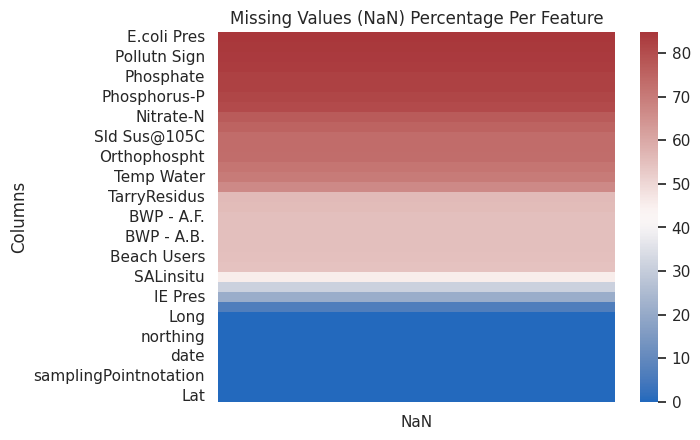

In [10]:
# checking out columns with more than nn% NaN
nn = 85
datasetxxn = datasetxx.drop(datasetxx.loc[:,list((100*(datasetxx.isnull().sum()/len(datasetxx.index))>nn))].columns, axis=1) 
print(datasetxxn.shape)
df = pd.DataFrame({'Columns': datasetxxn.columns, 'NaN': list((100*(datasetxxn.isnull().sum()/len(datasetxxn.index))))})
print(df)
plt.title('Missing Values (NaN) Percentage Per Feature')
df.set_index('Columns', inplace=True)
nans = df.NaN.sort_values(ascending=False).to_frame()
sns.heatmap(nans,cmap='vlag')

<Axes: >

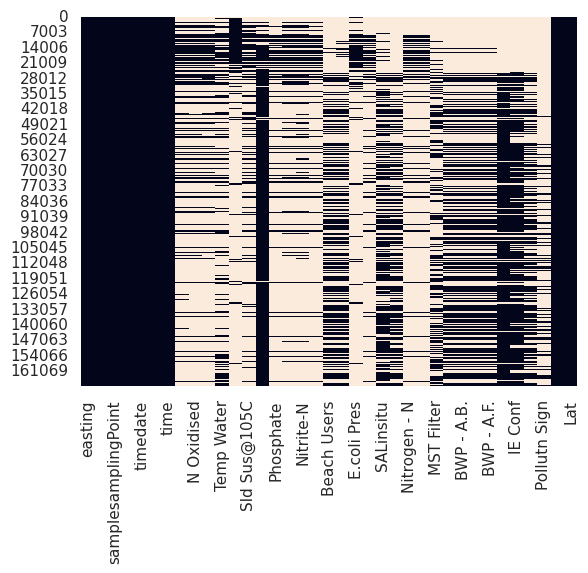

In [8]:
# checking the Nans distribution
miss = datasetxxn.isna()
sns.heatmap(miss,cbar=False)

### Keep features with atleast 5% (n=95) of valid measurements (not NaN)

In [22]:
# keep features with atleast 5% (n=95) of valid measurements (not NaN)
nn = 95
datasetxx = datasetxx.drop(datasetxx.loc[:,list((100*(datasetxx.isnull().sum()/len(datasetxx.index))>nn))].columns, axis=1) 
print(datasetxx.shape)

(168050, 56)


In [23]:
datasetxx.head()

,easting,northing,samplesamplingPoint,samplingPointnotation,timedate,date,time,Chloride Ion,BOD ATU,Ammonia(N),...,BWP - A.B.,BWP - O.L.,BWP - A.F.,IE Pres,IE Conf,TarryResidus,Beach Sign,Pollutn Sign,Long,Lat
0,583400.0,300900.0,http://environment.data.gov.uk/water-quality/i...,AN-48M06,2000-11-07 13:00:00,2000-11-07,13:00:00,25.5,1.6,0.054,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.705061,52.574987
1,580787.0,294455.0,http://environment.data.gov.uk/water-quality/i...,AN-48M08,2000-05-09 12:10:00,2000-05-09,12:10:00,34.6,1.0,0.034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.663039,52.517985
2,566300.0,337500.0,http://environment.data.gov.uk/water-quality/i...,AN-66M11,2000-05-25 09:30:00,2000-05-25,09:30:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.471512,52.909194
3,566300.0,337500.0,http://environment.data.gov.uk/water-quality/i...,AN-66M11,2000-06-14 11:50:00,2000-06-14,11:50:00,24.9,1.9,0.254,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.471512,52.909194
4,636000.0,260100.0,http://environment.data.gov.uk/water-quality/i...,AN-ALD020,2000-08-22 11:15:00,2000-08-22,11:15:00,78.4,1.0,0.030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.451225,52.188607


### Droping possible duplicated rows

In [33]:
datasetxx = datasetxx.drop_duplicates(subset=['timedate']).reset_index(drop=True)
datasetxx.shape

(165866, 52)

## Correlation Analysis

Correlation analysis on EA WQ archive data helps identify relationships between different variables with E.coli. A heatmap or correlation matrix is used to detect which features are strongly correlated with E. coli presence. This can help in feature selection.

### Correlation heatmap or matrix

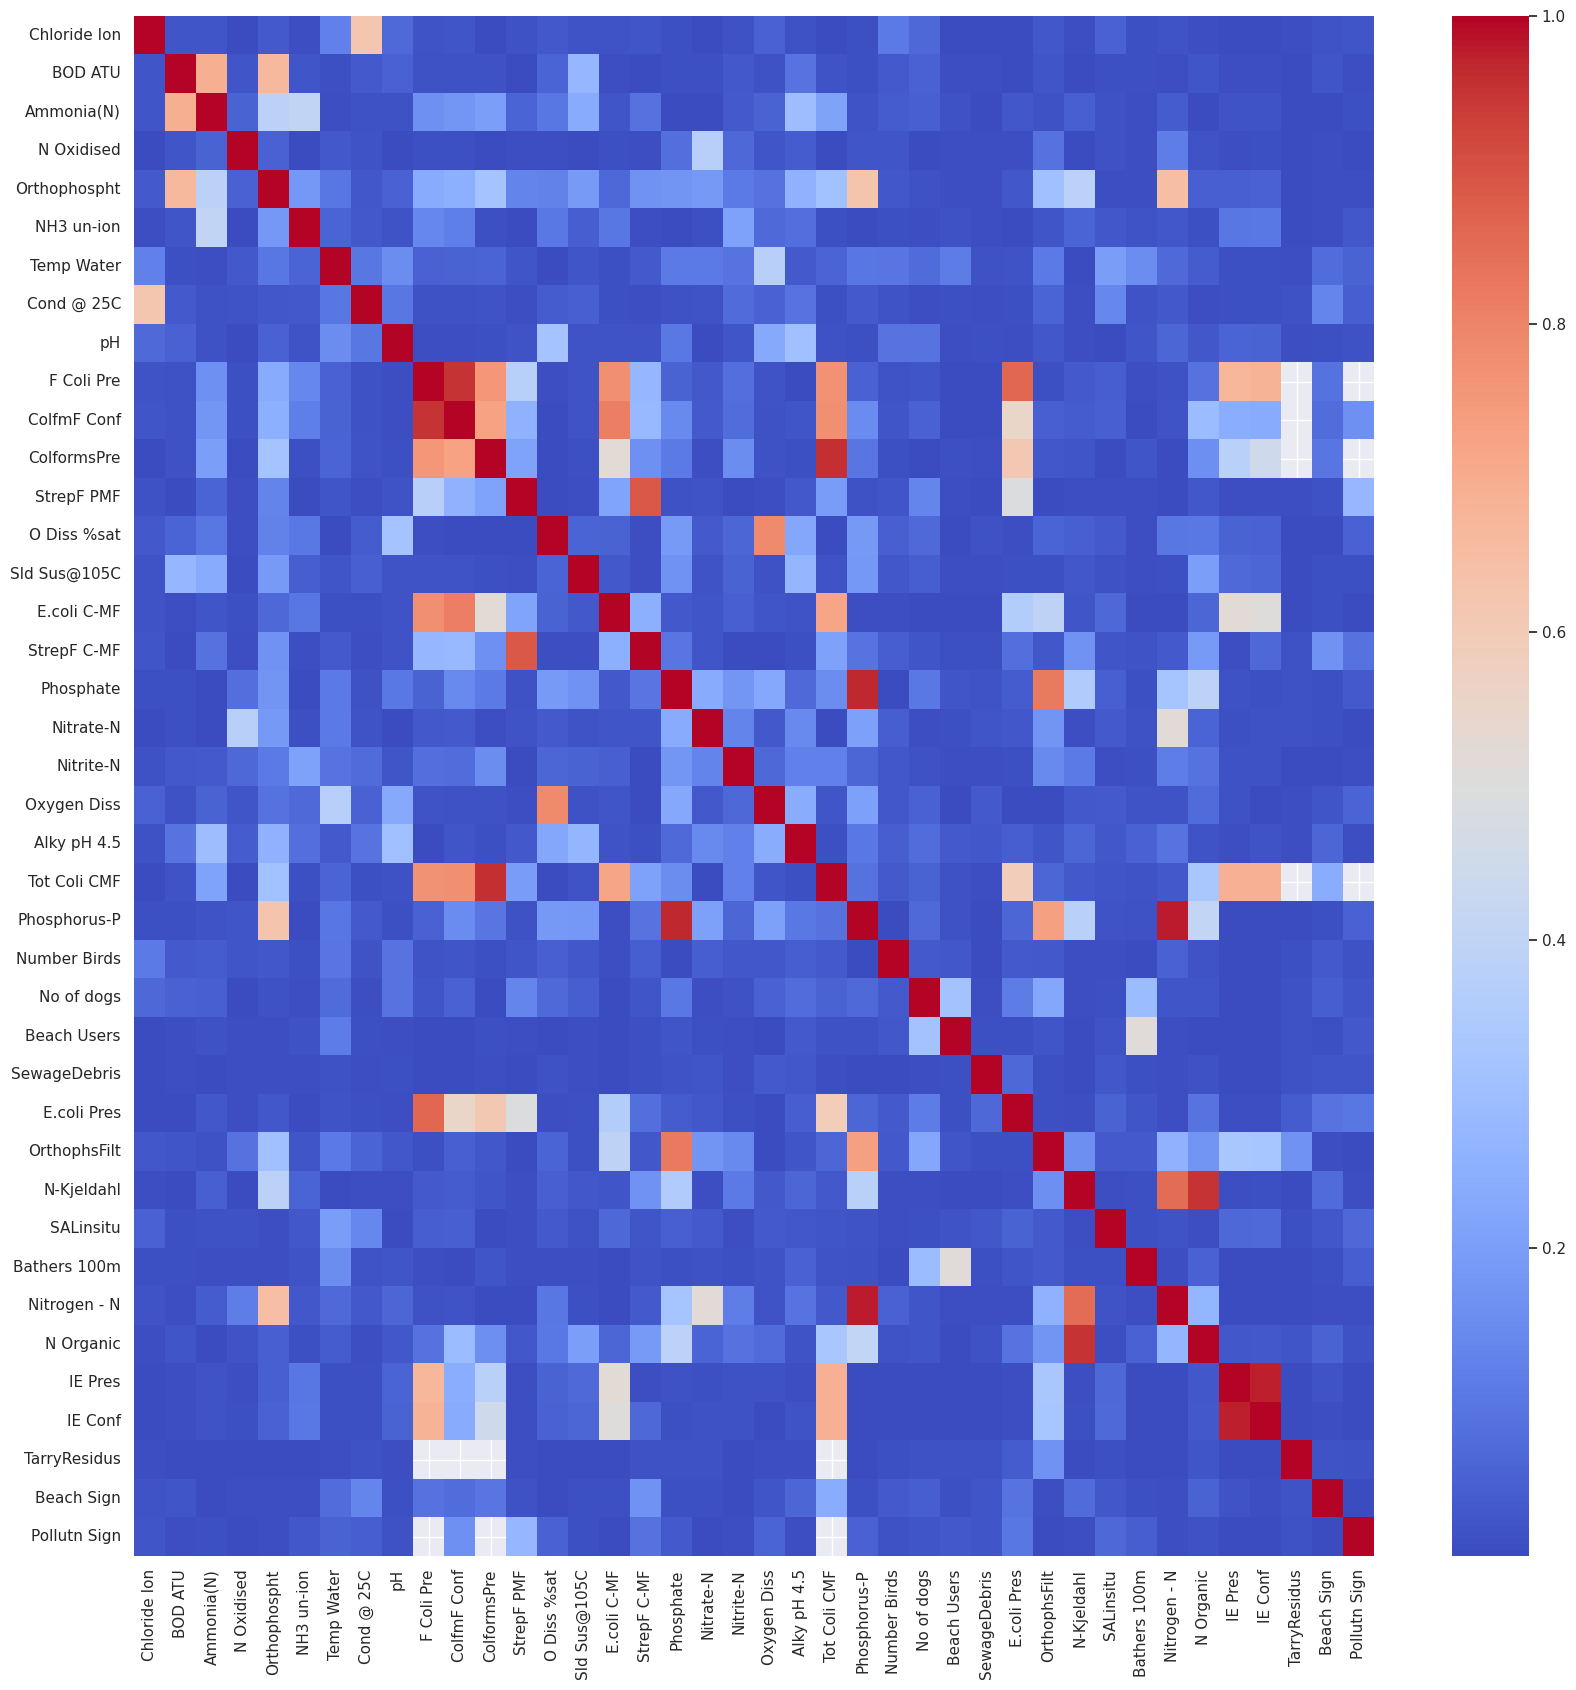

In [46]:
# dropping some irrelevant columns for simplicity in presentation
X = datasetxx.drop(['samplingPointnotation', 'samplesamplingPoint', 'timedate', 'date', 'time',
                   'BWP - A.B.', 'Vol Filtered','BWP - Ma','BWP - O.L.', 'BWP - A.F.','MST Filter','NATGRIDREF'],axis=1)
y = datasetxx['E.coli C-MF']

# correlation analysis
corre = X.corr().abs()
plt.figure(figsize=(20,20))
sns.heatmap(corre,annot=False,cmap="coolwarm")
plt.show()

### Spearman correlation against E.coli

<Axes: xlabel='E.coli C-MF', ylabel='None'>

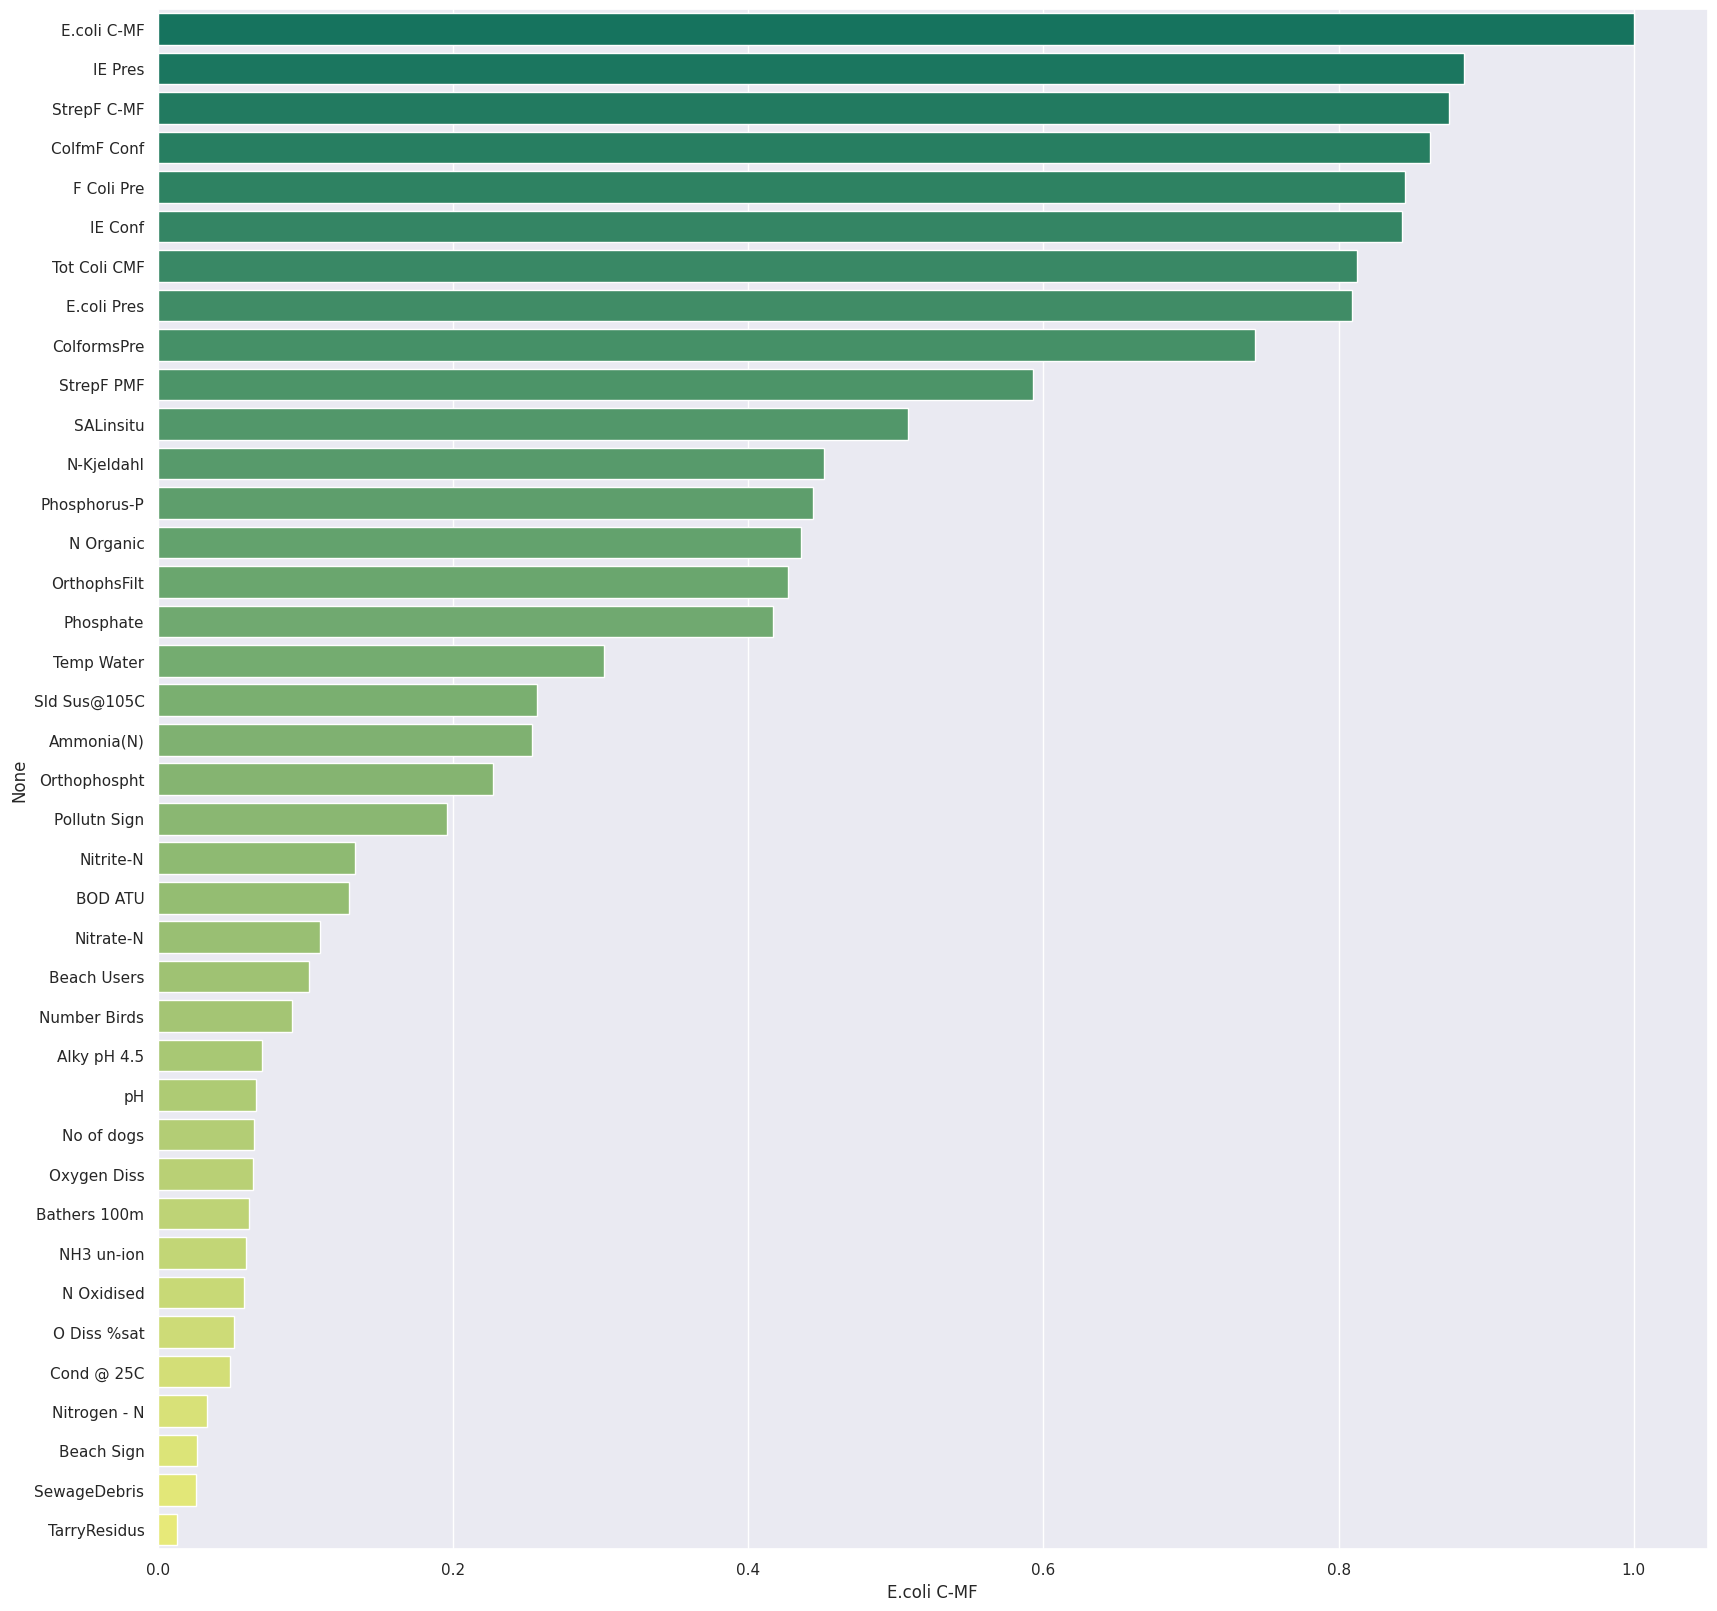

In [48]:
# correlation analysis for E.coli (Sorted)
temp = X.corr(method='spearman')[["E.coli C-MF"]].iloc[1: , :].abs() #kendall
temp = temp.sort_values('E.coli C-MF',ascending=False)
plt.figure(figsize=(20,20))
sns.barplot(x='E.coli C-MF',y=temp.index,data=temp,orient='h',palette='summer')

In [31]:
print(datasetxx.describe())

             easting       northing   Chloride Ion        BOD ATU  \
count  168050.000000  168050.000000   10919.000000   22686.000000   
mean   403440.081583  235441.931871     540.749911      74.582230   
std    140292.898350  183213.038839    3327.197499    1548.821044   
min    135560.000000       2.000000       1.000000       0.500000   
25%    301485.000000   80285.000000      26.450000       1.600000   
50%    367560.000000  163500.000000      42.600000       3.000000   
75%    517030.000000  438170.000000      86.300000       6.200000   
max    655400.000000  653826.000000  185000.000000  110000.000000   

         Ammonia(N)    N Oxidised  Orthophospht    NH3 un-ion    Temp Water  \
count  48021.000000  44826.000000  45172.000000  12406.000000  50430.000000   
mean       2.316029      4.311014      0.595613      0.008563     13.234197   
std       78.864237     13.844609      6.362884      0.106298      4.578712   
min        0.002000      0.012000      0.001000      0.000010 

### The top 5 most populated sampling locations are listed below.

In [29]:
grouped_data = datasetxx[['E.coli C-MF','Long','Lat']]
grouped_data = grouped_data.dropna().reset_index(drop=True)
grouped_data = grouped_data.groupby(["Lat", "Long"]).agg(
    ecoli_mean = ("E.coli C-MF","mean"),
    ecoli_count = ("E.coli C-MF","count")
).reset_index()
grouped_data.sort_values('ecoli_count',ascending=False).head()

,Lat,Long,ecoli_mean,ecoli_count
2019,53.859018,-2.743575,15933.951807,2490
2020,53.864080,-2.817993,13459.247653,2237
2,49.891933,-0.609131,104979.463187,2203
3,49.891942,-0.609131,93602.710771,1829
1,49.891924,-0.609131,21755.532724,1149


In [32]:
analysis = datasetxx.describe()

### Plot value counts

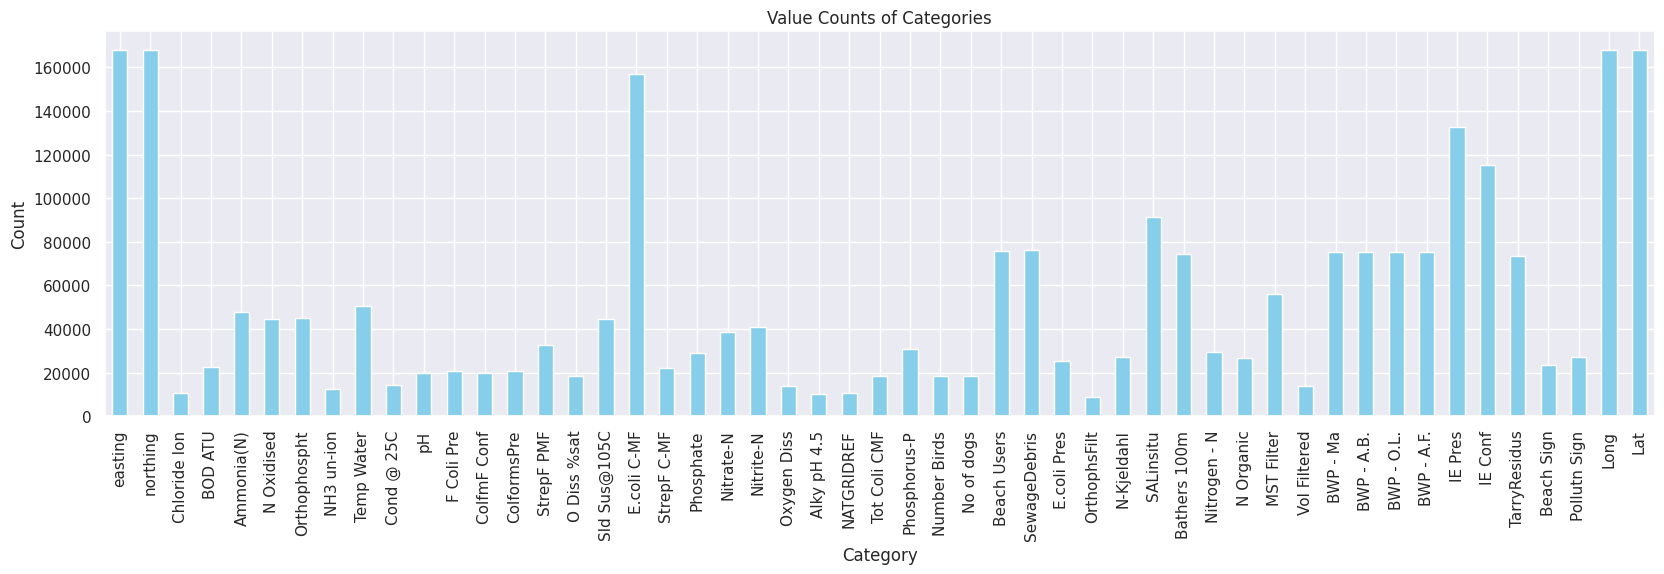

In [39]:
# Plot value counts
plt.figure(figsize=(20,5))
analysis.iloc[0].plot(kind='bar', color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Value Counts of Categories')
plt.show()

### Features distribution box plot

<Axes: >

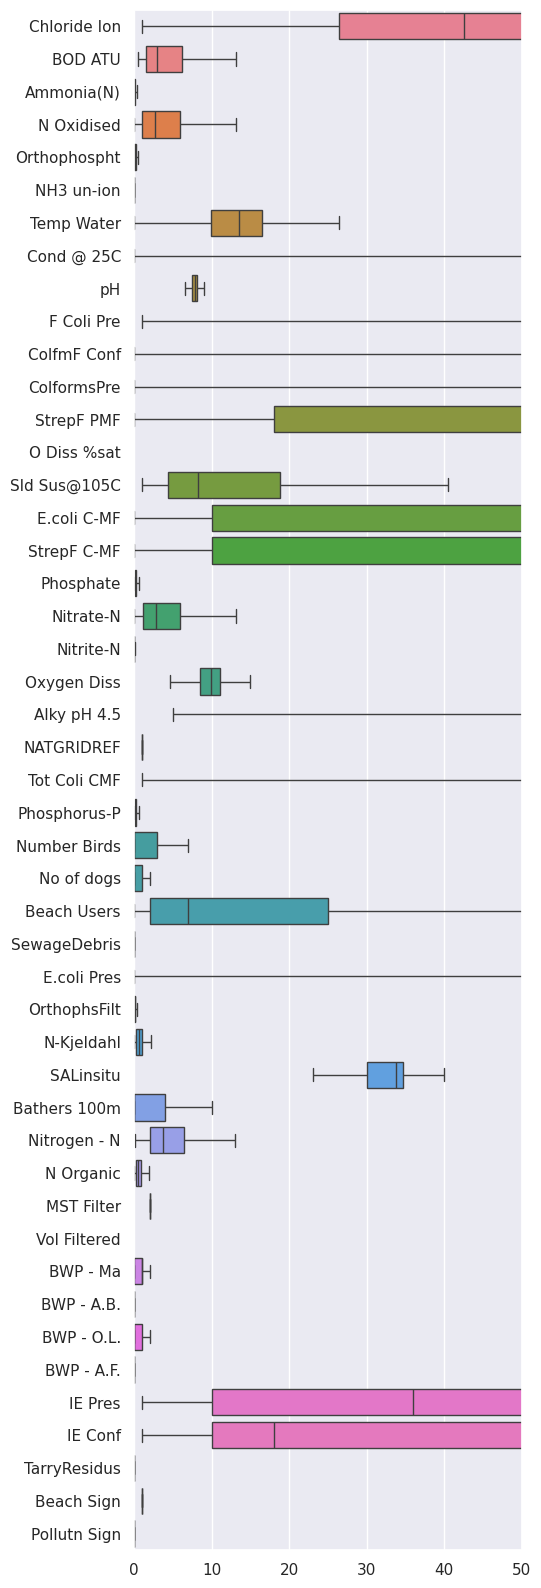

In [51]:
plt.figure(figsize=(5,20))
#plt.xlim(0, 50)
plt.xscale('log')
sns.boxplot(data = datasetxx.drop(['Lat', 'Long', 'easting', 'northing'],axis=1), orient="h", showfliers=False)

In [58]:
datasetxxt = datasetxx.drop_duplicates(subset=['timedate']).reset_index(drop=True)
datasetxxt = datasetxxt[["Temp Water", "Sld Sus@105C", "Ammonia(N)","Nitrate-N","Nitrite-N","Phosphate",
                        "Lat","Long","samplesamplingPoint","samplingPointnotation",
                        "timedate","time","date","E.coli C-MF"]]

datasetxxt = datasetxxt.dropna().reset_index(drop=True)
datasetxxt.head()

,Temp Water,Sld Sus@105C,Ammonia(N),Nitrate-N,Nitrite-N,Phosphate,Lat,Long,samplesamplingPoint,samplingPointnotation,timedate,time,date,E.coli C-MF
0,21.00,18.0,0.100,1.67,0.028,0.231,53.187897,-2.883978,http://environment.data.gov.uk/water-quality/i...,NW-689,2000-06-19 13:40:00,13:40:00,2000-06-19,625.0
1,13.70,5.3,1.370,0.90,0.100,0.036,52.709968,-0.600212,http://environment.data.gov.uk/water-quality/i...,AN-CACKASS1,2001-10-30 11:00:00,11:00:00,2001-10-30,10.0
2,14.50,4.0,0.630,5.64,0.132,1.200,53.249719,-1.874729,http://environment.data.gov.uk/water-quality/i...,MD-51705550,2004-07-29 10:30:00,10:30:00,2004-07-29,27.0
3,17.23,7.0,0.052,9.44,0.009,0.054,55.548752,-1.632269,http://environment.data.gov.uk/water-quality/i...,NE-42100095,2004-07-29 11:20:00,11:20:00,2004-07-29,280000.0
4,12.30,16.0,0.165,10.30,0.086,0.020,54.083600,-0.194554,http://environment.data.gov.uk/water-quality/i...,NE-49000063,2004-09-15 15:00:00,15:00:00,2004-09-15,370.0


In [3]:
#datasetxxt.to_csv('data/train_ecoli_all2_git.csv', index=False)
datasetxx = pd.read_csv('data/train_ecoli_all2_git.csv')
datasetxx.shape

(22202, 14)

In [13]:
import IPython
app = IPython.Application.instance() 
app.kernel.do_shutdown(restart=True)

{'status': 'ok', 'restart': True}

## Adding Weather Features Columns

Open-Meteo which is an open-source historical weather API is used to fetch weather data.

The Historical Weather API is based on reanalysis datasets and uses a combination of weather station, aircraft, buoy, radar, and satellite observations to create a comprehensive record of past weather conditions.

19 hourly, 13 daily and 13 weekly weather features are used where the detail can be found in the following table.

These weather data is incorporated, as environmental factors can influence E.coli levels. This step involve merging historical weather data with the existing dataset.

[This is the link to Open-Meteo Historical Weather API Docs.](https://open-meteo.com/en/docs/historical-weather-api)

Commercial clients require Commercial Use License: [For API plans check out here.](https://open-meteo.com/en/pricing)

In [ ]:
# Weather data columns from open-meteo API
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import time


# Load your water quality dataset
water_quality_df = datasetxx.copy()

# Ensure the 'date' column is in YYYY-MM-DD format
water_quality_df['date'] = pd.to_datetime(water_quality_df['date']).dt.strftime('%Y-%m-%d')

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Function to fetch weather data using the provided Open-Meteo API code
def fetch_weather(lat, lon, date):
    # for Paid API add "customer-" to the beginning of the url. also need to add the API key to parameters.
    url = "https://archive-api.open-meteo.com/v1/archive" 
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": (datetime.strptime(date, "%Y-%m-%d")  - timedelta(days=7)).strftime("%Y-%m-%d"),
        "end_date": date,
        "hourly": "temperature_2m,relative_humidity_2m,windspeed_10m,windgusts_10m,winddirection_10m,precipitation,rain,snowfall,cloudcover,pressure_msl,soil_temperature_0_to_7cm,soil_moisture_0_to_7cm,vapour_pressure_deficit,et0_fao_evapotranspiration,sunshine_duration,global_tilted_irradiance,shortwave_radiation,direct_radiation,dew_point_2m",
        "daily": "temperature_2m_min,temperature_2m_max,precipitation_sum,rain_sum,snowfall_sum,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,precipitation_hours,sunshine_duration,daylight_duration,shortwave_radiation_sum,et0_fao_evapotranspiration",
        "timezone": "GMT"
    }
    
    attempt = 0
    retries = 5
    while attempt < retries:
        try:
            responses = openmeteo.weather_api(url, params=params)
            attempt = retries
        except HTTPError as http_err:
            print(f"Rate limit reached. Retrying in {2 ** attempt} seconds...")
            time.sleep(0.1* 2 ** attempt)  # Exponential backoff
            attempt += 1
            cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
            retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
            openmeteo = openmeteo_requests.Client(session=retry_session)
        except Exception as e:
            # Handle other potential exceptions (network issues, etc.)
            print(f"Error: {e}")
            print(f"Rate limit reached. Retrying in {2 ** attempt} seconds...")
            time.sleep(0.1* 2 ** attempt)  # Exponential backoff
            attempt += 1
            cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
            retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
            openmeteo = openmeteo_requests.Client(session=retry_session)

    
    # Process the response for the first location (single request)
    response = responses[0]
    
    # Extract hourly data
    hourly = response.Hourly()
    hourly_data = {
        "temperature_11am": hourly.Variables(0).ValuesAsNumpy()[179], # index = 179 corresponds to the 11 o`clock 
        "humidity_11am": hourly.Variables(1).ValuesAsNumpy()[179],
        "windspeed_11am": hourly.Variables(2).ValuesAsNumpy()[179],
        "windgusts_11am": hourly.Variables(3).ValuesAsNumpy()[179],
        "winddirection_11am": hourly.Variables(4).ValuesAsNumpy()[179],
        "precipitation_11am": hourly.Variables(5).ValuesAsNumpy()[179],
        "rain_11am": hourly.Variables(6).ValuesAsNumpy()[179],
        "snowfall_11am": hourly.Variables(7).ValuesAsNumpy()[179],
        "cloudcover_11am": hourly.Variables(8).ValuesAsNumpy()[179],
        "pressure_msl_11am": hourly.Variables(9).ValuesAsNumpy()[179],
        "soil_temp_7cm": hourly.Variables(10).ValuesAsNumpy()[179],
        "soil_moist_7cm": hourly.Variables(11).ValuesAsNumpy()[179],
        "vap_press_def": hourly.Variables(12).ValuesAsNumpy()[179],
        "et0_fao_evap": hourly.Variables(13).ValuesAsNumpy()[179],
        "sun_duration": hourly.Variables(14).ValuesAsNumpy()[179],
        "global_tilted_irr": hourly.Variables(15).ValuesAsNumpy()[179],
        "short_rad": hourly.Variables(16).ValuesAsNumpy()[179],
        "dir_rad": hourly.Variables(17).ValuesAsNumpy()[179],
        "dew_point_2m": hourly.Variables(18).ValuesAsNumpy()[179]
    }
    
    # Extract daily data
    daily = response.Daily()
    daily_weather = {
        "temp_min": daily.Variables(0).ValuesAsNumpy()[7],  # index = 7 corresponds to the current day 
        "temp_max": daily.Variables(1).ValuesAsNumpy()[7],
        "precipitation_sum": daily.Variables(2).ValuesAsNumpy()[7],
        "rain_sum": daily.Variables(3).ValuesAsNumpy()[7],
        "snowfall_sum": daily.Variables(4).ValuesAsNumpy()[7],
        "windspeed_max": daily.Variables(5).ValuesAsNumpy()[7],
        "windgusts_max": daily.Variables(6).ValuesAsNumpy()[7],
        "winddirection_dominant": daily.Variables(7).ValuesAsNumpy()[7],
        "precipitation_hours": daily.Variables(8).ValuesAsNumpy()[7],
        "sunshine_duration_d": daily.Variables(9).ValuesAsNumpy()[7],
        "daylight_duration_d": daily.Variables(10).ValuesAsNumpy()[7],
        "short_rad_sum_d": daily.Variables(11).ValuesAsNumpy()[7],
        "et0_fao_evap_d": daily.Variables(12).ValuesAsNumpy()[7]
    }
    
    
    # Extract weekly data
    weekly_weather = {
        "temp_min7": daily.Variables(0).ValuesAsNumpy().mean(),
        "temp_max7": daily.Variables(1).ValuesAsNumpy().mean(),
        "precipitation_sum7": daily.Variables(2).ValuesAsNumpy().sum(),
        "rain_sum7": daily.Variables(3).ValuesAsNumpy().sum(),
        "snowfall_sum7": daily.Variables(4).ValuesAsNumpy().sum(),
        "windspeed_max7": daily.Variables(5).ValuesAsNumpy().mean(),
        "windgusts_max7": daily.Variables(6).ValuesAsNumpy().mean(),
        "winddirection_dominant7": daily.Variables(7).ValuesAsNumpy().mean(),
        "precipitation_hours7": daily.Variables(8).ValuesAsNumpy().sum(),
        "sunshine_duration_d7": daily.Variables(9).ValuesAsNumpy().sum(),
        "daylight_duration_d7": daily.Variables(10).ValuesAsNumpy().sum(),
        "short_rad_sum_d7": daily.Variables(11).ValuesAsNumpy().sum(),
        "et0_fao_evap_d7": daily.Variables(12).ValuesAsNumpy().sum()
    }
    return {**hourly_data, **daily_weather, **weekly_weather}



Add new columns to your DataFrame for hourly and daily parameters

In [ ]:
# Add new columns to your DataFrame for hourly and daily parameters
hourly_columns = ["temperature_11am", "humidity_11am", "windspeed_11am", "windgusts_11am", 
                    "winddirection_11am", "precipitation_11am", "rain_11am", "snowfall_11am",
                    "cloudcover_11am", "pressure_msl_11am","soil_temp_7cm","soil_moist_7cm","vap_press_def",
                  "et0_fao_evap","sun_duration","global_tilted_irr","short_rad","dir_rad","dew_point_2m"]
daily_columns = ["temp_min", "temp_max", "precipitation_sum", "rain_sum", "snowfall_sum",
                    "windspeed_max", "windgusts_max", "winddirection_dominant",
                    "precipitation_hours", "sunshine_duration_d", "daylight_duration_d", "short_rad_sum_d", "et0_fao_evap_d"]
weekly_columns = ["temp_min7", "temp_max7", "precipitation_sum7", "rain_sum7", "snowfall_sum7",
                    "windspeed_max7", "windgusts_max7", "winddirection_dominant7",
                    "precipitation_hours7", "sunshine_duration_d7", "daylight_duration_d7", "short_rad_sum_d7", "et0_fao_evap_d7"]

program_starts = time.time()
j = 0
for col in hourly_columns + daily_columns + weekly_columns:
    water_quality_df[col] = None

# Iterate over each row in the DataFrame to fetch weather data
for idx, row in water_quality_df.iterrows():
    try:
        weather_data = fetch_weather(row["Lat"], row["Long"], row["date"])
    except:
        
        # Setup the Open-Meteo API client with cache and retry on error
        cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
        retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
        openmeteo = openmeteo_requests.Client(session=retry_session)
        print("API limit hit.")
        time.sleep(34)  # to cope with API limit
        weather_data = fetch_weather(row["Lat"], row["Long"], row["date"])
        
    if weather_data:
        for col in weather_data.keys():
            water_quality_df.at[idx, col] = weather_data[col]
    
    # Pause to avoid hitting rate limits
    time.sleep(0.01) 
    j = j + 1
    if j%100 == 0:
        now = time.time()
        print("It has been {0} sec and {1} iterations since the loop started".format(now - program_starts, j))
        import openmeteo_requests
        import requests_cache
        import pandas as pd
        from retry_requests import retry
        # Setup the Open-Meteo API client with cache and retry on error
        cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
        retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
        openmeteo = openmeteo_requests.Client(session=retry_session)

    

# Save the updated DataFrame
water_quality_df.to_csv("train_ecoliall51_weather.csv", index=False)
water_quality_df.shape

In [ ]:
water_quality_df.shape

In [ ]:
# to save the dataframes of water_quality_df after hitting daily API limit
df1 = water_quality_df.iloc[:j,:]
df1.to_csv("dfl12.csv", index=False)
print(j)

In [ ]:
# concate the dataframes of water_quality_df after fetching all samples
# This parts can be ignored as we used it for training data preperation
# Respecting API limits (hourly, daily and monthly) can be followed to avoid concating approach
df_merged = pd.concat([df1, df2], ignore_index=True, sort=False)

In [ ]:
datasetxx = pd.read_csv('data/train_ecoliall51_weather.csv')
table = pa.Table.from_pandas(datasetxx)
pq.write_table(table, "data/train_ecoliall51_weather.parquet") # to be shared on GitHub

## Final Analysis on Generated Data

In [3]:
table2 = pq.read_table('data/train_ecoliall51_weather.parquet')
datasetxx = table2.to_pandas()
datasetxx = datasetxx[['Temp Water', 'Sld Sus@105C', 'Ammonia(N)','Nitrate-N','Nitrite-N', 'Lat','Long','Phosphate','samplesamplingPoint',
                        'samplingPointnotation','timedate','time','date','E.coli C-MF', 'temperature_11am', 'humidity_11am',
                        'windspeed_11am', 'windgusts_11am', 'winddirection_11am',
                        'precipitation_11am', 'rain_11am', 'snowfall_11am', 'cloudcover_11am',
                        'pressure_msl_11am', 'soil_temp_7cm', 'soil_moist_7cm', 'vap_press_def',
                        'et0_fao_evap', 'sun_duration', 'global_tilted_irr', 'short_rad',
                        'dir_rad', 'dew_point_2m', 'temp_min', 'temp_max', 'precipitation_sum',
                        'rain_sum', 'snowfall_sum', 'windspeed_max', 'windgusts_max',
                        'winddirection_dominant', 'precipitation_hours',
                        'sunshine_duration_d', 'daylight_duration_d', 'short_rad_sum_d',
                        'et0_fao_evap_d', 'temp_min7', 'temp_max7', 'precipitation_sum7',
                        'rain_sum7', 'snowfall_sum7', 'windspeed_max7', 'windgusts_max7',
                        'winddirection_dominant7', 'precipitation_hours7',
                        'sunshine_duration_d7', 'daylight_duration_d7', 'short_rad_sum_d7',
                        'et0_fao_evap_d7']]
datasetxx.shape

(21064, 59)

<Axes: xlabel='E.coli C-MF', ylabel='None'>

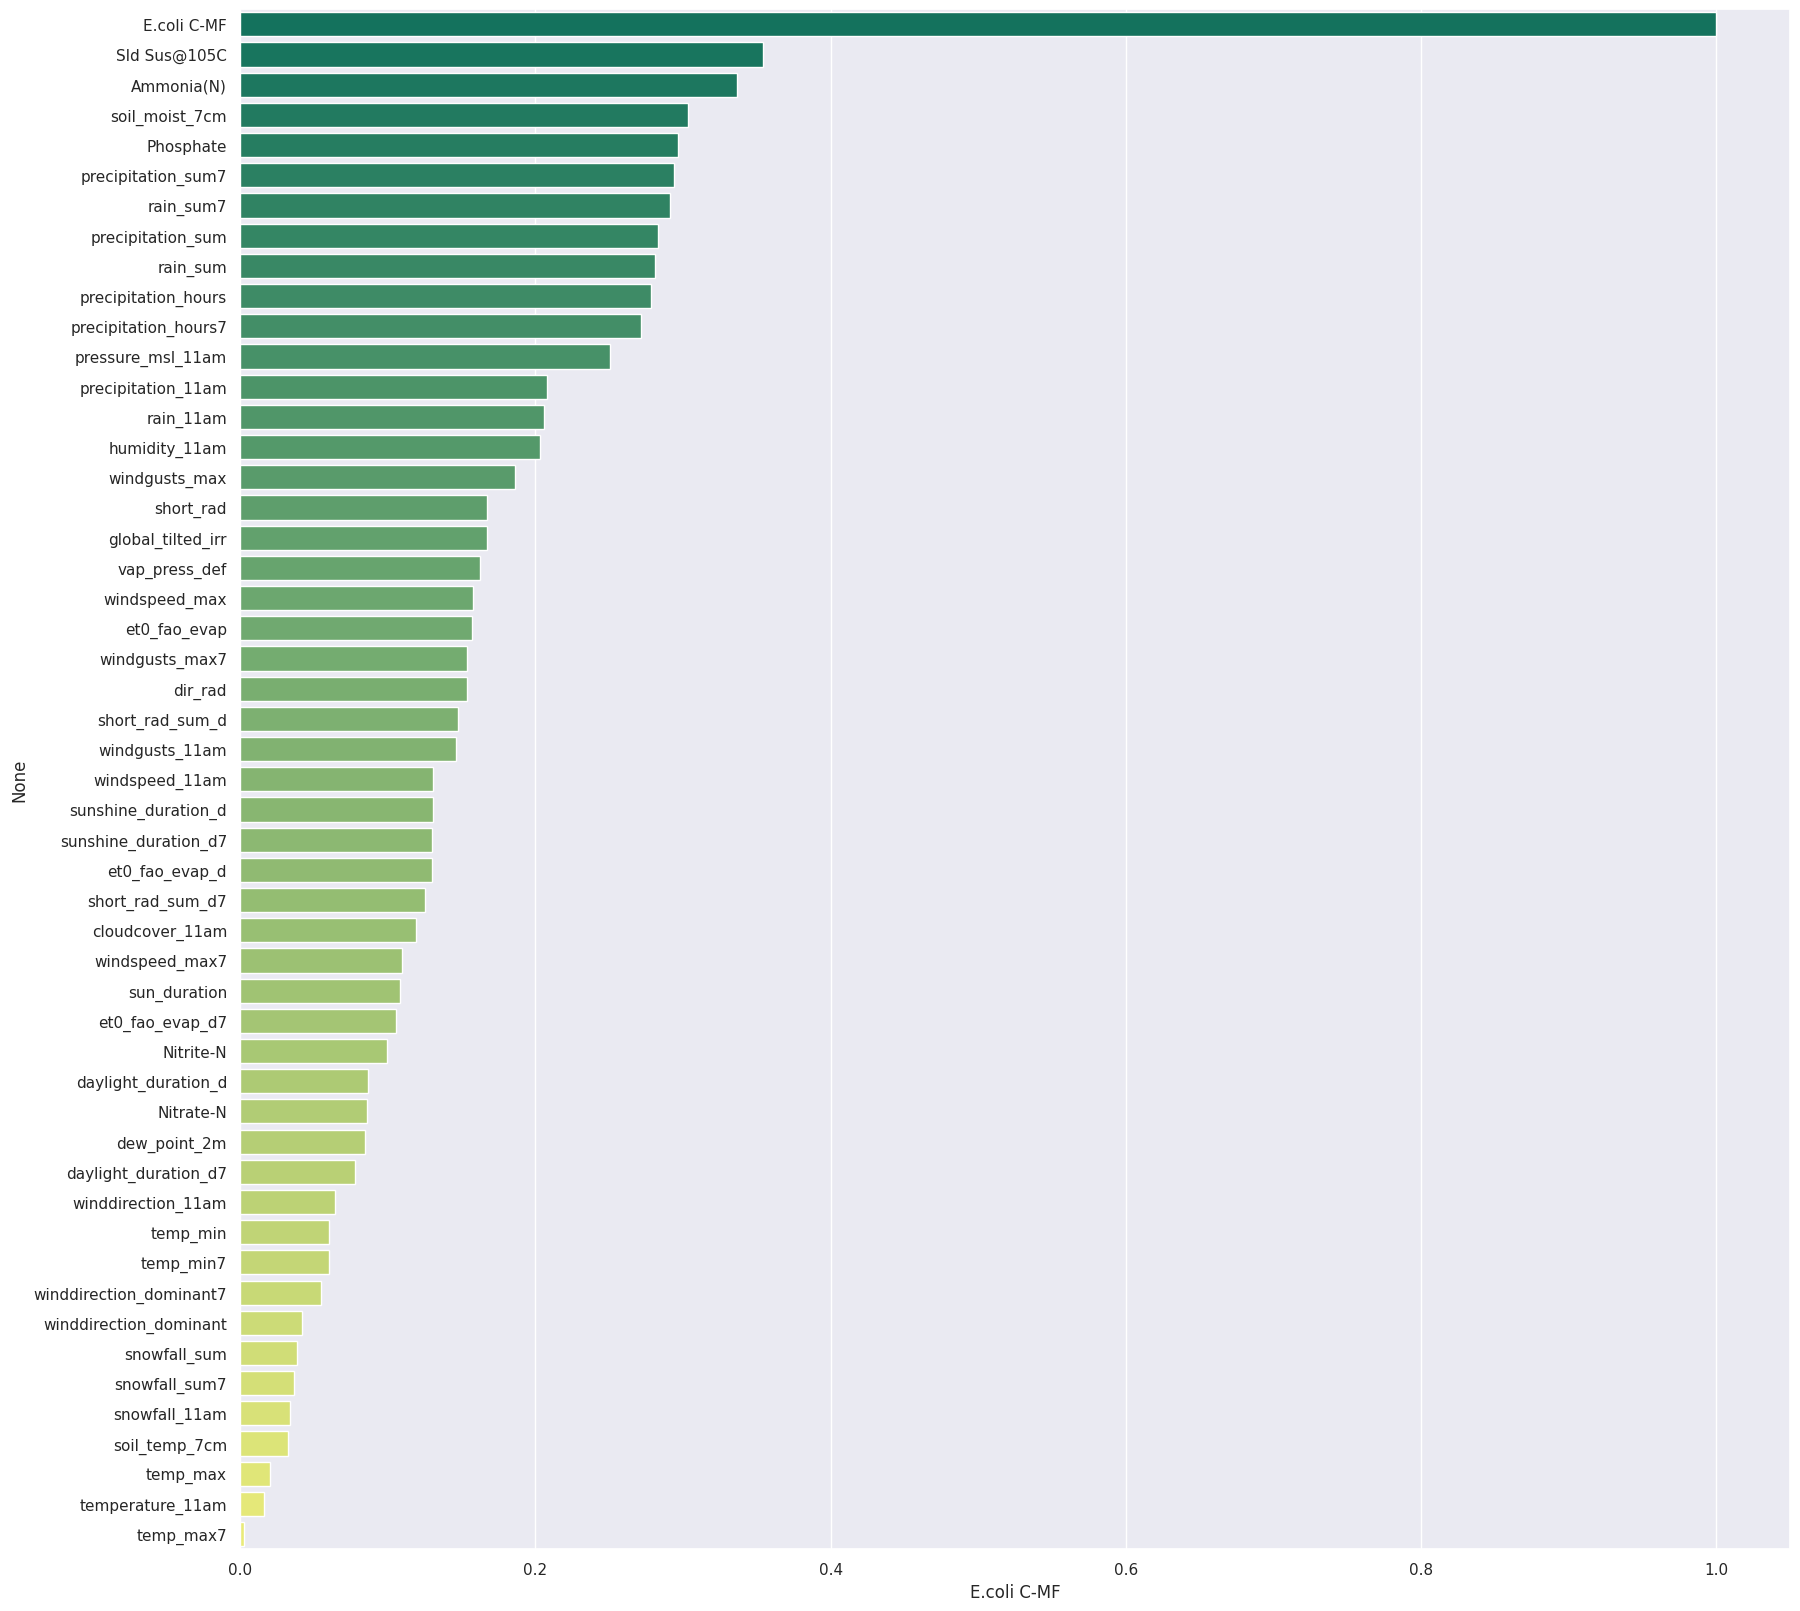

In [4]:
# correlation analysis for E.coli (Sorted)
X = datasetxx.drop(['samplingPointnotation', 'samplesamplingPoint', 
                    'timedate', 'date', 'time', 'Lat', 'Long'],axis=1)
y = datasetxx['E.coli C-MF']

# correlation analysis
corre = X.corr().abs()
temp = X.corr(method='spearman')[["E.coli C-MF"]].iloc[1: , :].abs() #kendall
temp = temp.sort_values('E.coli C-MF',ascending=False)
plt.figure(figsize=(20,20))
sns.barplot(x='E.coli C-MF',y=temp.index,data=temp,orient='h',palette='summer')

<Axes: >

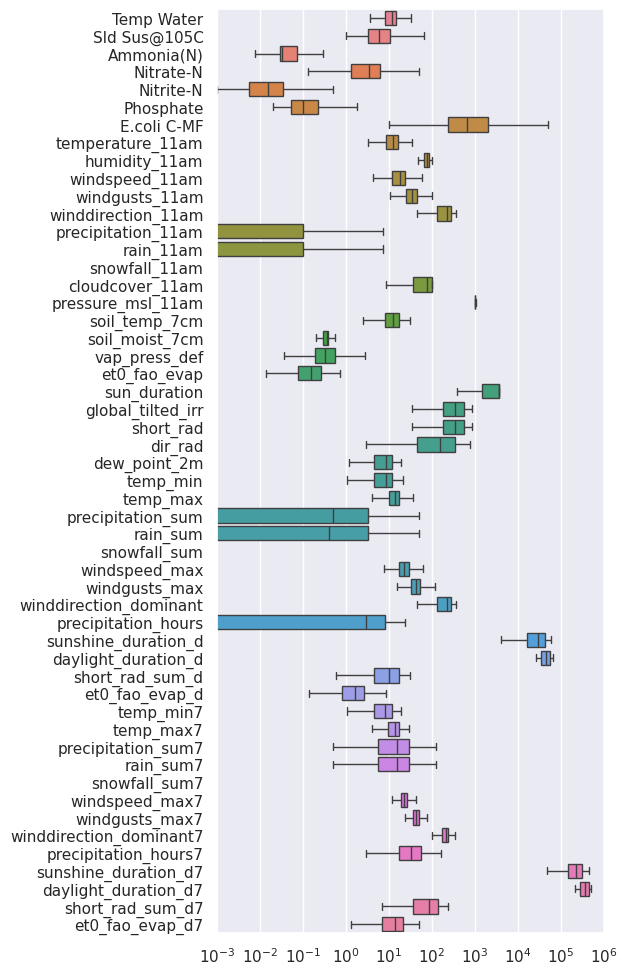

In [5]:
# Features distribution box plot
plt.figure(figsize=(5,12))
plt.xlim(0.001,1000000)
plt.xscale('log')
sns.boxplot(data = datasetxx.drop(['Lat', 'Long','samplesamplingPoint',
                        'samplingPointnotation','timedate', ],axis=1), orient="h", showfliers=False)


time series does not have regular time steps, the fallback_bin_method'gaussian' is applied
time series does not have regular time steps, the fallback_bin_method'gaussian' is applied
time series does not have regular time steps, the fallback_bin_method'gaussian' is applied
time series does not have regular time steps, the fallback_bin_method'gaussian' is applied
time series does not have regular time steps, the fallback_bin_method'gaussian' is applied
The correlation is above 1 or below -1. This can occur due to the binning method used. Please check the data and the binning method and use the autocorrelation function with extreme care.
time series does not have regular time steps, the fallback_bin_method'gaussian' is applied
time series does not have regular time steps, the fallback_bin_method'gaussian' is applied
The correlation is above 1 or below -1. This can occur due to the binning method used. Please check the data and the binning method and use the autocorrelation function with e

ACF averaged on 19 sampling locations


Text(0, 0.5, 'Mean Autocorrelation')

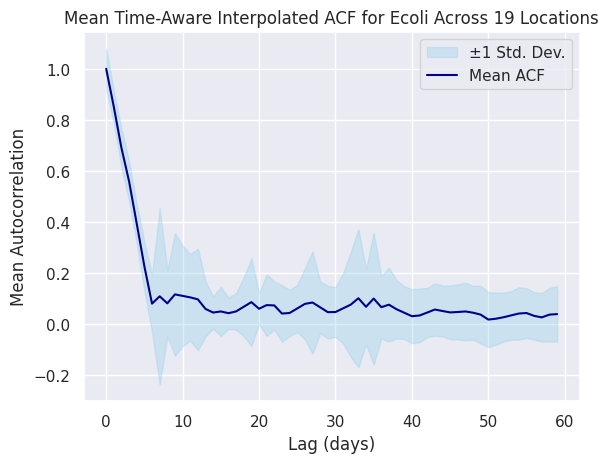

In [11]:
# Time-Aware Autocorrelation Function (ACF) on E. coli
import pastas as ps

grouped_data = datasetxx[['E.coli C-MF','Long','Lat']]
grouped_data = grouped_data.dropna().reset_index(drop=True)
grouped_data = grouped_data.groupby(["Lat", "Long"]).agg(
    ecoli_mean = ("E.coli C-MF","mean"),
    ecoli_count = ("E.coli C-MF","count")
).reset_index()

acf_matrix = []
lags = np.arange(0, 60, 1)
for j, i in enumerate(range(len(grouped_data))):
    lat = grouped_data.sort_values('ecoli_count',ascending=False).Lat.iloc[i]
    lon = grouped_data.sort_values('ecoli_count',ascending=False).Long.iloc[i]
    filtered_df = datasetxx[(datasetxx['Lat'] == lat) & (datasetxx['Long'] == lon)]

    if len(filtered_df) < 10:
        break  # skip loctions with very short series
        
    # Step 2: Ensure datetime index
    filtered_df['date'] = pd.to_datetime(filtered_df['date'])
    filtered_df.set_index('date', inplace=True)

    # Step 3: Drop missing values
    ecoli_series = filtered_df['E.coli C-MF'].dropna()

    # Step 4: ACF
    try:
        acf_result = ps.stats.acf(ecoli_series, lags=lags)
    except:
        continue
        
    # Only continue if result has enough points
    if len(acf_result) < 3:
        break # skip ACF with very short series
        
    # Interpolate to common lags (in days)
    acf_interp = np.interp(lags, acf_result.index.days, acf_result.values)
    acf_matrix.append(acf_interp)
    

# Step 5: Convert to Numpy array and compute average
acf_array = np.array(acf_matrix)
mean_acf = np.nanmean(acf_array, axis=0)  # average across remained locations
std_acf = np.nanstd(acf_array, axis=0)

print(f'ACF averaged on {len(acf_array[:])} sampling locations')

# Plot the average Interpolated ACF
plt.fill_between(lags, mean_acf - std_acf, mean_acf + std_acf,
                 alpha=0.3, color='skyblue', label='±1 Std. Dev.')
plt.plot(lags, mean_acf, color='darkblue', label='Mean ACF')
plt.legend()
plt.title(f'Mean Time-Aware Interpolated ACF for Ecoli Across {len(acf_array[:])} Locations')
plt.xlabel('Lag (days)')
plt.ylabel('Mean Autocorrelation')